In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch import Tensor
import math
from PIL import Image

In [31]:
batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../cifar', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../cifar', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


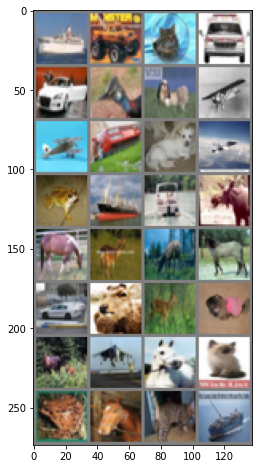

 ship


In [32]:
# functions to show an image
import cv2

#res = cv2.resize(img, dsize=(54, 140), interpolation=cv2.INTER_CUBIC)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images, nrow=4))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [33]:
patch_width = 4 # patch_width = patch_height
step = 4
n_channels = 3
num_patches = int(32**2 / patch_width**2)
flat_patch_size = patch_width**2 * 3

def image_to_flat_patches(image_batch):
    """
    Partition the image into square patches and flatten them. 
    Color channels are concatenated.
    
    Args: 
        image_batch: shape [batch_size, n_channels, width, height]
    
    Return:
        flat_patches: shape [batch_size, num_patches, patch_length^2 * n_channels]
    """
    # Divide the image into patches

    patches = image_batch.unfold(2, patch_width, step).unfold(3, patch_width, step).permute(0, 2, 3, 1, 4, 5).reshape(image_batch.shape[0], -1, n_channels, patch_width, patch_width)
    flat_patches = patches.reshape(image_batch.shape[0], num_patches, -1) # shape: [batch_size, n_patches, patch_length^2 * n_channels]

    return flat_patches
    

# Define Transformer Model

In [34]:
class BEITModel(nn.Module):
    # patch_size = patch_width * patch_height * 3
    def __init__(self, patch_size: int = 48, nhead: int = 3, d_hid: int = 128, n_layers: int = 3):
        super().__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=patch_size, nhead=nhead, dim_feedforward=d_hid,
                                                    dropout=0, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
        self.pos_encoder = PositionalEncoding(patch_size)
        self.last_layer = nn.Linear(patch_size, patch_size)
        self.tanh = nn.Tanh()

    def forward(self, masked_patches) -> Tensor:
        """
        Args:
            flat_patches: Tensor of shape: [batch_size, n_patches, patch_size] 
            (n_patches = seq_len, patch_size = patch_length^2 * n_channels).
        Returns:
            predicted_patches: Tensor of same shape as patches.
        """
        
        masked_patches_pos = self.pos_encoder(masked_patches)
        #masked_idxs is a list of masked indices (each entry is a tensor of shape: [])
        trained_patches = self.transformer_encoder(masked_patches_pos)
        trained_patches = self.last_layer(trained_patches)
        trained_patches = self.tanh(trained_patches)
        
        return trained_patches
        

In [35]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 2000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        # without this modification, it would throw an error for uneven d_model
        if d_model % 2 == 0:
            pe[:, 1::2] = torch.cos(position * div_term)
        else:
            pe[:, 1::2] = torch.cos(position * div_term)[:, 0:-1]
        pe = pe.unsqueeze(0)  # pe shape[1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor of embedded peaks, shape [batch_size, n_patches, patch_size]  (patch_size is equal to d_model)
        """
        x = x + self.pe[:, :x.size(1)]
        x = x.squeeze(0)
        return self.dropout(x)


In [36]:
# patches shape: [batch_size, n_patches, patch_size]
def mask_input(flat_patches, mask_prob=0.2):
    masked_patches = [] # list of masked patches (one entry = one image)
    masked_idxs = [] # list of indices that got masked
    non_masked_idxs = [] # list of indices that did not get masked
    
    # iterate through the images and mask some patches
    for image_patches in flat_patches:
        image_patches = image_patches.detach().clone()

        # we only need the first dimension i.e. the number of patches per image to create the mask
        rand = torch.rand(image_patches.shape[0], device=image_patches.device)
        # create mask array
        mask_arr = (rand < mask_prob) # * (peak_idxs_cls != C.CLS) * (peak_idxs_cls != C.PAD)
        mask_arr_labels = ~mask_arr
        mask_idxs = torch.flatten(mask_arr.nonzero())  # indices which get a MASK token, are replaced or stay the same
        non_mask_idxs = torch.flatten(mask_arr_labels.nonzero())  # indices that dont get masked
        
        # MASK with 80% prob
        rand = torch.rand(len(mask_idxs))
        actual_mask_idxs = rand < 0.8
        actual_mask_idxs = mask_idxs[actual_mask_idxs]
        image_patches[actual_mask_idxs] = torch.zeros(flat_patches.shape[2]) # masked patches are replaced with zeros
        # actual_mask_idxs contains patch idxs that get masked and mask_idxs contains 80% masked and 20% unchanged patches
        
        masked_patches.append(image_patches)
        masked_idxs.append(mask_idxs)
        non_masked_idxs.append(non_mask_idxs)
        
    masked_patches = torch.stack(masked_patches)
    #masked_idxs = torch.stack(masked_idxs)

    return masked_patches, masked_idxs, non_masked_idxs

# Training

In [50]:
num_epochs = 5
#network = BEITModel(flat_patch_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(network.parameters(), lr=0.001, weight_decay=0.01, betas=(0.9, 0.98))

running_loss = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1} / {num_epochs}')
    network.train()
    losses = []
    i = 0

    for data_batch in trainloader:
        i +=1
        images, labels = data_batch
        flat_patches = image_to_flat_patches(images)
        # mask 15% of patches
        masked_patches, masked_idxs, non_masked_idxs = mask_input(flat_patches, 0.3)
        network.zero_grad()
        
        trained_patches = network(masked_patches)
        
        batch_losses = []
        # only calculate the loss for masked patches
        for image, trained_image, idx in zip(flat_patches, trained_patches, masked_idxs):
            if not idx.numel():
                continue # emtpy tensor, i.e. not masked patches
            loss = loss_function(image[idx], trained_image[idx])
            batch_losses.append(loss)

        #print(loss.item())
        total_loss = sum(batch_losses)
        total_loss.backward()
        
        #total_loss = loss_function(flat_patches, trained_patches)
        #total_loss.backward()
        
        optimizer.step()

        losses.append(total_loss.item())
        
        running_loss += total_loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    print(f'{np.mean(losses)} loss in epoch {epoch + 1}')

PATH = './BEIT_model4.pth'
torch.save(network.state_dict(), PATH)

Epoch 1 / 5
[1,  1000] loss: 1.030
1.0204924785282394 loss in epoch 1
Epoch 2 / 5
[2,  1000] loss: 1.560
0.9938746401497895 loss in epoch 2
Epoch 3 / 5
[3,  1000] loss: 1.533
0.9715615877034339 loss in epoch 3
Epoch 4 / 5
[4,  1000] loss: 1.498
0.95287714634503 loss in epoch 4
Epoch 5 / 5
[5,  1000] loss: 1.471
0.9368185311918142 loss in epoch 5


In [48]:
PATH = './BEIT_model4.pth'
network = BEITModel()
network.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [40]:
def flat_patches_to_patches(flat_patches, patch_width):
    patches = flat_patches.reshape(flat_patches.shape[0], num_patches, 3, patch_width, patch_width) # reshape back to 2D patches
    return patches
    
def patches_to_images(patches):
    # patches shape: [batch_size, n_patches, n_channels, patch_width, patch_width]
    # output shape: [batch_size, n_channels, 32, 32]
    fold = nn.Fold(output_size=(32, 32), kernel_size=(4, 4), stride=(4, 4))

    patches = patches.reshape(patches.shape[0], patches.shape[1], -1)
    patches = patches.permute(0, 2, 1)
    patches = fold(patches)
    #patches = patches.permute(0, 2, 1, 3, 4)
    return patches.reshape(patches.shape[0], 3, 32, 32)
    

In [41]:
#dataiter = iter(trainloader)
dataiter = iter(testloader)


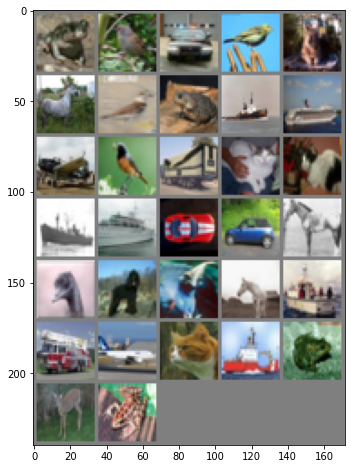

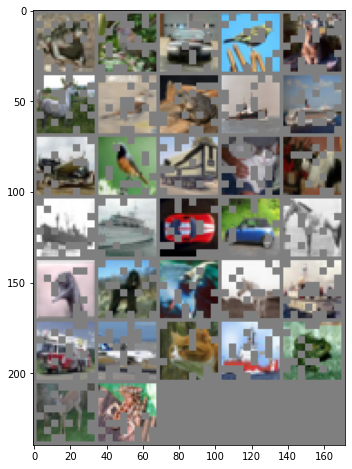

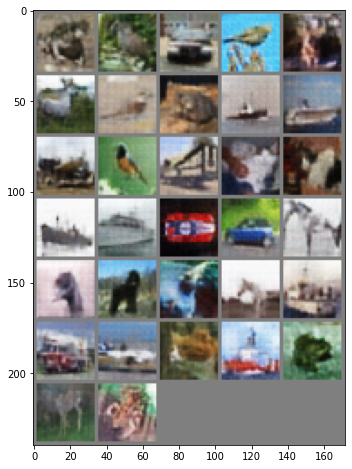

In [49]:
images, labels = dataiter.next()
flat_patches = image_to_flat_patches(images)
patches = flat_patches_to_patches(flat_patches, patch_width)
masked_patches, masked_idxs, non_masked_idxs = mask_input(flat_patches, 0.3)


trained_patches = network(masked_patches)
trained_patches = flat_patches_to_patches(trained_patches, patch_width)
masked_patches = flat_patches_to_patches(masked_patches, patch_width)

images = patches_to_images(patches)
masked_images = patches_to_images(masked_patches)
trained_images = patches_to_images(trained_patches)

imshow(torchvision.utils.make_grid(images, nrow=5))
imshow(torchvision.utils.make_grid(masked_images, nrow=5))
imshow(torchvision.utils.make_grid(trained_images, nrow=5))

nr = 2
#imshow(torchvision.utils.make_grid(trained_patches[nr][[0,1]], nrow=8))
#imshow(torchvision.utils.make_grid(masked_patches[nr], nrow=8))
#imshow(torchvision.utils.make_grid(patches[nr], nrow=8))

In [18]:
from torchvision.utils import save_image

for i, image in enumerate(images):
    save_image(image/ 2 + 0.5, f"images/test_save{i}.jpg")

In [43]:
from itertools import chain


# one patch has width/height 4*4
def patch_idx_to_positions(x_idxs, y_idxs):
    for x_idx, y_idx in zip(x_idxs, y_idxs):
        # x_positions for idx 0: [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]
        # y_positions for idx 0:
        x_positions = [list(range(idx*4, idx*4+4))*4 for idx in x_idxs]  
        x_positions = list(chain.from_iterable(x_positions))  # unlist
        y_positions = [range(idx*4, idx*4+4) for idx in y_idxs]
        y_positions = list(np.repeat(y_positions, 4))
    return x_positions, y_positions
    

# image shape: [3, 32, 32]
# x_idxs: list of x idx to be masked  (0 <= idx <= 7)
# y_idxs: list of y ixs to be masked
def mask_image_at_idxs(image, x_idxs, y_idxs):
    x_positions, y_positions = patch_idx_to_positions(x_idxs, y_idxs)
    image[:, x_positions, y_positions] = 0
    


In [44]:
patch_width

4

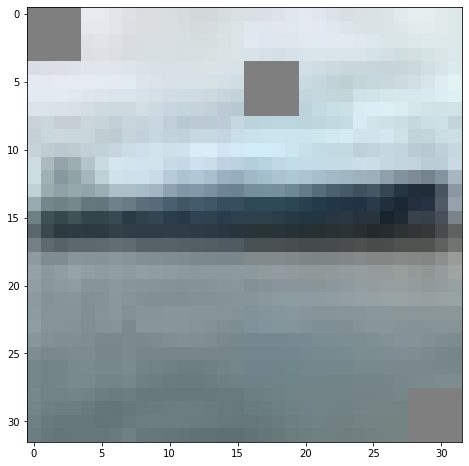

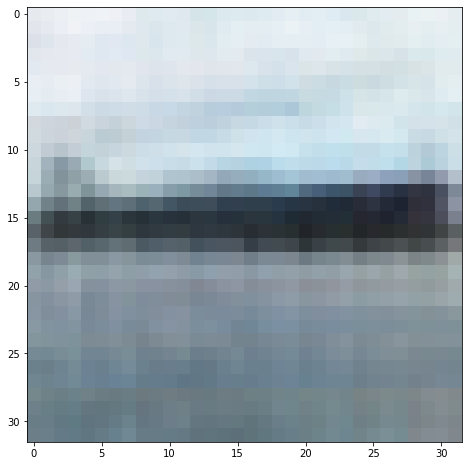

In [45]:
img = Image.open("images/test_save7.jpg")
img = transform(img)
# mask desired patches

mask_image_at_idxs(img, [0, 1, 7], [0, 4, 7])  # inplace
img = img.unsqueeze(0)


flat_patches = image_to_flat_patches(img)
trained_patches = network(flat_patches)
trained_patches = trained_patches.squeeze().unsqueeze(0)
trained_patches = flat_patches_to_patches(trained_patches, patch_width)
trained_images = patches_to_images(trained_patches)

imshow(torchvision.utils.make_grid(img, nrow=5))
imshow(torchvision.utils.make_grid(trained_images, nrow=5))


In [28]:
flat_patches = image_to_flat_patches(img)
# mask 15% of patches
masked_patches, masked_idxs, non_masked_idxs = mask_input(flat_patches, 0.15)